In [1]:
import numpy as np
import matplotlib.pyplot as pp
import seaborn

In [2]:
%matplotlib inline

In [3]:
#import urllib.request
#urllib.request.urlretrieve('ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt','stations.txt')

In [4]:
stations = {}

for line in open('stations.txt','r'):
    if 'GSN' in line:
        fields = line.split()
        
        stations[fields[0]] = ' '.join(fields[4:])

In [5]:
def findstation(s):
    found = {code: name for code,name in stations.items() if s in name}
    print(found)

In [6]:
def parsefile(filename):
    return np.genfromtxt(filename,
                         delimiter = dly_delimiter,
                         usecols = dly_usecols,
                         dtype = dly_dtype,
                         names = dly_names)

In [7]:
dly_delimiter = [11,4,2,4] + [5,1,1,1] * 31
dly_usecols = [1,2,3] + [4*i for i in range(1,32)]
dly_dtype = [np.int32,np.int32,(np.str_,4)] + [np.int32] * 31
dly_names = ['year','month','obs'] + [str(day) for day in range(1,31+1)]

In [8]:
def unroll(record):
    startdate = np.datetime64('{}-{:02}'.format(record['year'],record['month']))
    dates = np.arange(startdate,startdate + np.timedelta64(1,'M'),np.timedelta64(1,'D'))
    
    rows = [(date,record[str(i+1)]/10) for i,date in enumerate(dates)]
    
    return np.array(rows,dtype=[('date','M8[D]'),('value','d')])

In [9]:
def getobs(filename,obs):
    data = np.concatenate([unroll(row) for row in parsefile(filename) if row[2] == obs])
    
    data['value'][data['value'] == -999.9] = np.nan
    
    return data

In [10]:
def fillnans(data):
    dates_float = data['date'].astype(np.float64)
    
    nan = np.isnan(data['value'])
    
    data['value'][nan] = np.interp(dates_float[nan],dates_float[~nan],data['value'][~nan])

In [11]:
def selectyear(data,year):
    start = np.datetime64('{}'.format(year))
    end = start + np.timedelta64(1,'Y')
    
    return data[(data['date'] >= start) & (data['date'] < end)]['value']

In [12]:
findstation('MINNEAPOLIS')
findstation('SAN DIEGO')

{'USW00014922': 'MN MINNEAPOLIS/ST PAUL AP GSN HCN 72658'}
{'USW00023188': 'CA SAN DIEGO LINDBERGH FLD GSN 72290'}


In [13]:
minn_tmax = getobs('USW00014922.dly','TMAX')
minn_tmin = getobs('USW00014922.dly','TMIN')

In [14]:
san_tmax = getobs('USW00023188.dly','TMAX')
san_tmin = getobs('USW00023188.dly','TMIN')

In [15]:
fillnans(minn_tmax)
fillnans(minn_tmin)
fillnans(san_tmax)
fillnans(san_tmin)

In [16]:
years = np.arange(1940, 2015)

In [17]:
minn_tmax_all = np.vstack([selectyear(minn_tmax, year)[:365] for year in years])
minn_tmin_all = np.vstack([selectyear(minn_tmin, year)[:365] for year in years])

In [18]:
minn_mean = np.mean(minn_tmax_all, axis=1)

In [19]:
minn_mean

array([ 11.83917808,  13.82547945,  12.75561644,  11.87452055,
        13.12520548,  11.6430137 ,  13.43260274,  12.54328767,
        13.36410959,  13.54219178,  10.8569863 ,  10.44876712,
        12.80109589,  13.64356164,  12.78493151,  12.96191781,
        12.65589041,  12.49863014,  13.10438356,  12.94986301,
        12.18849315,  12.48767123,  11.22136986,  12.85616438,
        13.30027397,  11.0890411 ,  11.89205479,  11.47780822,
        12.64821918,  12.27178082,  12.07945205,  12.01835616,
        10.28465753,  13.11643836,  12.26849315,  12.26465753,
        13.88438356,  12.65945205,  12.21123288,  11.47726027,
        12.87780822,  13.33589041,  12.05726027,  12.1709589 ,
        12.2860274 ,  11.75835616,  12.51917808,  15.14986301,
        13.84164384,  12.12493151,  14.04356164,  12.83013699,
        12.28273973,  11.29589041,  12.78767123,  12.55753425,
        11.15534247,  12.08328767,  14.54383562,  14.02438356,
        12.90739726,  13.54109589,  12.88109589,  12.93

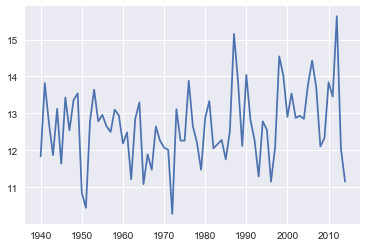

In [20]:
pp.plot(years, minn_mean)

In [21]:
minn_warm = years[np.argmax(minn_mean)]
minn_warm

2012

In [22]:
san_tmin_all = np.vstack([selectyear(san_tmin, year)[:365] for year in years])
san_mean = np.mean(san_tmin_all, axis=1)

In [23]:
san_cold = years[np.argmin(san_mean)]
san_cold

1948

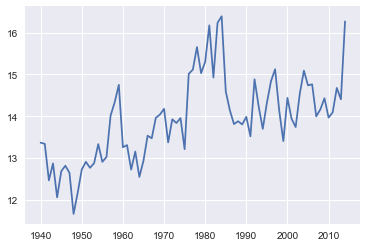

In [24]:
pp.plot(years, san_mean)

In [25]:
days = np.arange(1, 367)

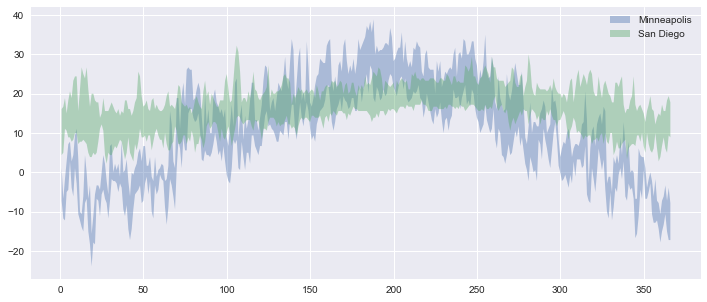

In [29]:
pp.figure(figsize=(12,5))
pp.fill_between(days, selectyear(minn_tmin, minn_warm), selectyear(minn_tmax, minn_warm), alpha=0.4)
pp.fill_between(days, selectyear(san_tmin, san_cold), selectyear(san_tmax, san_cold), alpha=0.4)

pp.legend(['Minneapolis', 'San Diego'])